**Poprzednie zadanie**

Poprzednie zadanie do tego raczej pokazało mi że w dużej mierze hiperparametry które są dobierane podczas tworzenia modelu, są bardzo ważne ponieważ mogą spowodować omylne wnioski i złą interpretacje. Są też często konieczne do tego żeby określić czy w modelu doszło do overfitting-u czy jednak do underfitting-u.

**Import bibliotek**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Podział danych**

Dane dzielę zgodnie z sugestią na zbiory: treningowy, walidacyjny oraz testowy.

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Pobranie danych (zapisze do folderu ./data)
data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

# Podział danych na train/val
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128 # (16,32,64)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=False)

print("Zbiór treningowy:", len(train_ds))
print("Zbiór walidacyjny:", len(val_ds))
print("Zbiór testowy:", len(test_ds))

Zbiór treningowy: 55000
Zbiór walidacyjny: 5000
Zbiór testowy: 10000


**Wyświetlenie danych**


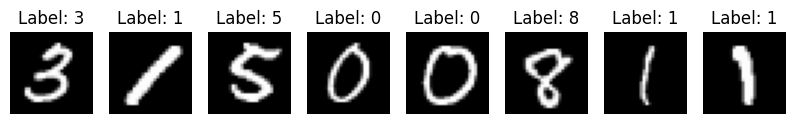

In [13]:
# W ramach sprawdzenia wyświetlam dane ze zbioru
images, labels = next(iter(train_loader))
images = images[:8]
labels = labels[:8]

fig, axes = plt.subplots(1, len(images), figsize=(10, 6))
for ax, img, lab in zip(axes, images, labels):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {lab.item()}")
    ax.axis("off")
plt.show()

**Baseline (MLP)**


Zdecydowałem się na zrobienie "prostego" Baseline-a na bazie sieci MLP, gdzie niekoniecznie chciałem osiągnąć pozytywne wyniki. Głównym celem było sprawdzenie w jaki sposób sieć poradzi sobie stosując jak najmniejsze zasoby, dlatego sieć posiada jedynie jedną warstwę ukrytą.

Zatem całość wygląda następująco:
*   Wejście (w naszym przypadku: 784 piks.) -> Linear (784 -> 128 piks.) -> ReLU (f. aktywacji) -> Linear (128 -> 10 piks.) -> Wyjście



Podczas wyświetlania wyników będę wyświetlał dokładną wartość metryki "accuracy". Pozostałe metryki (recall, precision oraz F1-score) nie uznałem za konieczne, ponieważ w przypadku zbioru danych "MNIST" dane są raczej "zbalansowane" (zbiór raczej posiada mniej-więcej taką samą ilość każdej cyfry) co za sobą by niosło jedynie sprawdzenie czy faktycznie zgadliśmy poprawny wynik.

In [44]:
class BaselineFC(nn.Module):
    def __init__(self):
        super().__init__()
        #Ustawienie warstw ukrytych
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Spłaszczenie zbioru
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaselineFC().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [45]:
# Zbiory metryk
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
test_losses, test_accuracies = [], []
# Ustawienie ilości epok
EPOCHS = 5

start = time.time()

for epoch in range(EPOCHS):
    # Zbiór treningowy
    model.train()
    running_loss, correct, total = 0, 0, 0
    all_train_preds, all_train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    # Zbiór walidacyjny
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Zbiór testowy
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total

    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    # Wyświetlenie wyników epoki
    print(f"Epoka {epoch+1}/{EPOCHS} | "
          f"train loss: {avg_loss:.4f}, acc: {acc:.2f}% | "
          f"val loss: {avg_val_loss:.4f}, acc: {val_acc:.2f}% | "
          f"test loss: {avg_test_loss:.4f}, acc: {test_acc:.2f}%")

end = time.time()
print(f"Czas treningu: {end - start:.1f}s")

Epoka 1/5 | train loss: 0.8117, acc: 81.28% | val loss: 0.4402, acc: 87.92% | test loss: 0.4050, acc: 89.13%
Epoka 2/5 | train loss: 0.3745, acc: 89.58% | val loss: 0.3626, acc: 89.62% | test loss: 0.3230, acc: 90.95%
Epoka 3/5 | train loss: 0.3200, acc: 90.79% | val loss: 0.3276, acc: 90.52% | test loss: 0.2913, acc: 91.81%
Epoka 4/5 | train loss: 0.2898, acc: 91.72% | val loss: 0.3008, acc: 91.42% | test loss: 0.2678, acc: 92.48%
Epoka 5/5 | train loss: 0.2679, acc: 92.39% | val loss: 0.2817, acc: 91.90% | test loss: 0.2508, acc: 92.93%
Czas treningu: 103.4s


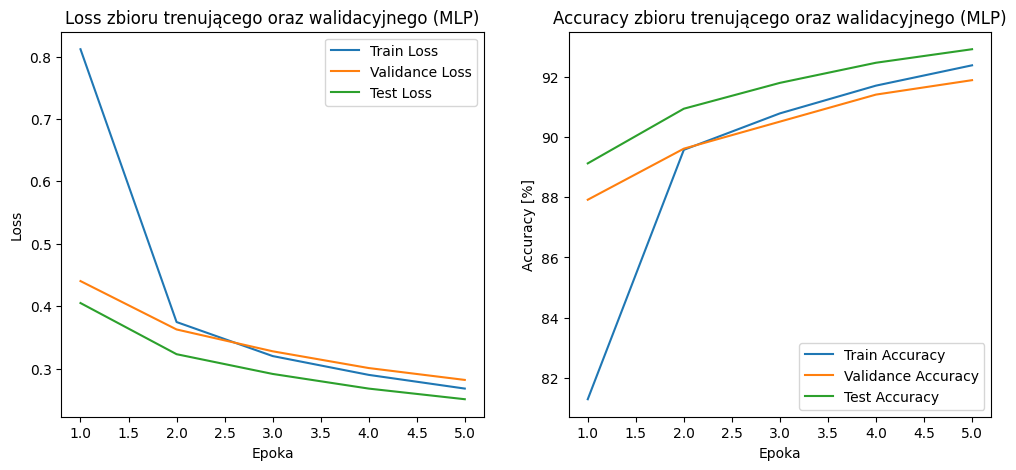

In [46]:
#Wizualizacje wyników Acc. oraz Loss
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validance Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.title("Loss zbioru trenującego oraz walidacyjnego (MLP)")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validance Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.title("Accuracy zbioru trenującego oraz walidacyjnego (MLP)")
plt.xlabel("Epoka")
plt.ylabel("Accuracy [%]")
plt.legend()

plt.show()

Wyniki są następujące:

*   Zbiór walidacyjny (od pewnej epoki) zaczyna mieć większe straty oraz mniejszy parametr "accuracy".
*   Pomimo tego że sieć wykorzystuje jedynie jedną warstwę ukrytą, nie wykorzystuje zaawansowanych optymalizatorów oraz nie wykorzystuje dropout-u to widoczne jest że wyniki po 5 iteracjach są w stanie osiągnąć ok. 90%.
*   Widoczne są również lepsze wyniki na zbiorze testowym, po 5 iteracjach jest w stanie osiągnąć powyżej. 92%, co (wliczając że sieć nie posiada za dużo "narzędzi" do korzystania) wydaję się być dobrym wynikiem.

Widoczne jest zatem że sposób uczenia jak i ilość warstw ukrytych które posiada sieć będzie dedykować jakie wyniki dana sieć uzyska.

**CNN**


Podobnie jak do poprzedniego modelu będę chciał wyświetlić metrykę "accuracy" oraz "stratę, aby na nich wnioskować jak dana sieć sobie radzi. Całość wygląda następująco:
*   Wejście -> Warstwa konwolucyjna #1 -> ReLU -> Zmniejszenie rozmiaru -> Warstwa konw. #2 -> ReLU -> Zmniejszenie rozmiaru -> Wyjście




In [48]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Warstwy konwolucyjne
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Spłaszczenie danych
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
# Zbiory metryk
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
test_losses, test_accuracies = [], []
# Ustawienie ilości epok
EPOCHS = 5

start = time.time()

for epoch in range(EPOCHS):
    # Zbiór treningowy
    model.train()
    running_loss, correct, total = 0, 0, 0
    all_train_preds, all_train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    # Zbiór walidacyjny
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Zbiór testowy
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total

    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    # Wyświetlenie wyników epoki
    print(f"Epoka {epoch+1}/{EPOCHS} | "
          f"train loss: {avg_loss:.4f}, acc: {acc:.2f}% | "
          f"val loss: {avg_val_loss:.4f}, acc: {val_acc:.2f}% | "
          f"test loss: {avg_test_loss:.4f}, acc: {test_acc:.2f}%")

end = time.time()
print(f"Czas treningu: {end - start:.1f}s")

Epoka 1/5 | train loss: 0.1785, acc: 94.66% | val loss: 0.0721, acc: 98.00% | test loss: 0.0541, acc: 98.22%
Epoka 2/5 | train loss: 0.0478, acc: 98.49% | val loss: 0.0617, acc: 98.26% | test loss: 0.0474, acc: 98.48%
Epoka 3/5 | train loss: 0.0327, acc: 98.97% | val loss: 0.0544, acc: 98.64% | test loss: 0.0382, acc: 98.68%
Epoka 4/5 | train loss: 0.0243, acc: 99.23% | val loss: 0.0430, acc: 98.76% | test loss: 0.0334, acc: 98.86%
Epoka 5/5 | train loss: 0.0200, acc: 99.34% | val loss: 0.0393, acc: 98.92% | test loss: 0.0308, acc: 99.01%
Czas treningu: 418.6s


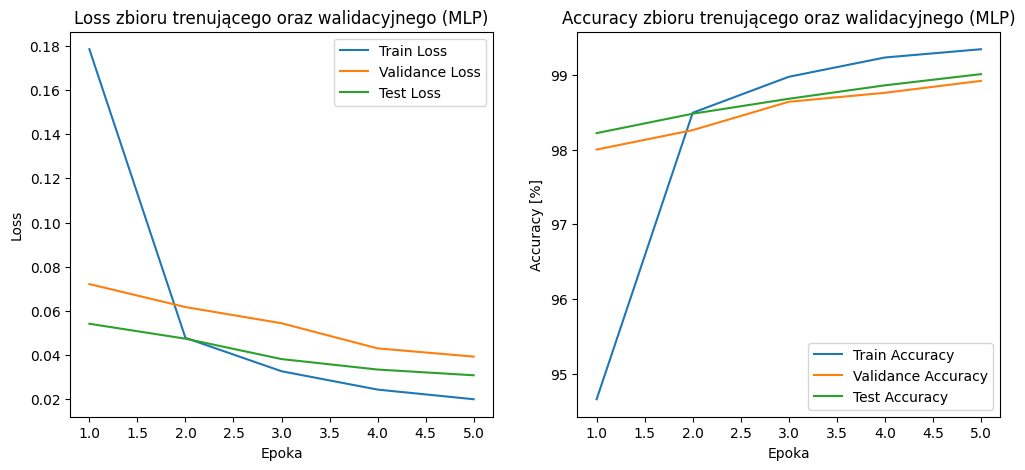

In [50]:
#Wizualizacje wyników Acc. oraz Loss
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validance Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.title("Loss zbioru trenującego oraz walidacyjnego (MLP)")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validance Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.title("Accuracy zbioru trenującego oraz walidacyjnego (MLP)")
plt.xlabel("Epoka")
plt.ylabel("Accuracy [%]")
plt.legend()

plt.show()

Wyniki są następujące:

*   Podobnie jak z siecią MLP, zbiór walidacyjny (od pewnej epoki) posiada więcej strat oraz mniejszy parametr "accuracy" (podobnie jest ze zbiorem testowym).
*   Wyniki są z kolei dość wysokie, ale dla pełnej działalności najprawdopodobjniej będzie potrzeba na większa liczbę iteracji.
*   CNN wymaga o wiele większej siły obliczeniowej w porównaniu do MLP, a na to wskazuje chociażby czas (ok. 418 sek.) który potrzebował na wykonanie treningu.

Wydaję się że model może osiągnąć lepsze wyniki (np. zbiór walidacyjny nie ustąpi zbiorowi treningowemu), dlatego dodam do tego modelu DropOut oraz BatchNorm.


**Zmiany parametrów i ich wpływ na sieci**

Ze względu na lepsze wyniki sieci **CNN** uznałem że na niej sprawdzę, jak się sieć zachowa dodając **DropOut** oraz **BatchNorm**.

In [52]:
# Ten sam CNN ale z DropOut oraz Batch Norm
class secondCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Warstwy konwolucyjne
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)

        # Dropout 25%
        self.dropout = nn.Dropout(0.25)

        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Spłasczenie oraz odłączenie węzłów
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = secondCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [53]:
# Zbiory metryk
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
test_losses, test_accuracies = [], []
# Ustawienie ilości epok
EPOCHS = 5

start = time.time()

for epoch in range(EPOCHS):
    # Zbiór treningowy
    model.train()
    running_loss, correct, total = 0, 0, 0
    all_train_preds, all_train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    # Zbiór walidacyjny
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Zbiór testowy
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total

    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    # Wyświetlenie wyników epoki
    print(f"Epoka {epoch+1}/{EPOCHS} | "
          f"train loss: {avg_loss:.4f}, acc: {acc:.2f}% | "
          f"val loss: {avg_val_loss:.4f}, acc: {val_acc:.2f}% | "
          f"test loss: {avg_test_loss:.4f}, acc: {test_acc:.2f}%")

end = time.time()
print(f"Czas treningu: {end - start:.1f}s")

Epoka 1/5 | train loss: 0.1728, acc: 94.62% | val loss: 0.0605, acc: 98.30% | test loss: 0.0476, acc: 98.30%
Epoka 2/5 | train loss: 0.0677, acc: 97.89% | val loss: 0.0466, acc: 98.76% | test loss: 0.0339, acc: 98.84%
Epoka 3/5 | train loss: 0.0515, acc: 98.40% | val loss: 0.0365, acc: 98.82% | test loss: 0.0320, acc: 98.95%
Epoka 4/5 | train loss: 0.0459, acc: 98.59% | val loss: 0.0368, acc: 98.86% | test loss: 0.0297, acc: 99.09%
Epoka 5/5 | train loss: 0.0385, acc: 98.75% | val loss: 0.0372, acc: 99.08% | test loss: 0.0278, acc: 99.12%
Czas treningu: 542.3s


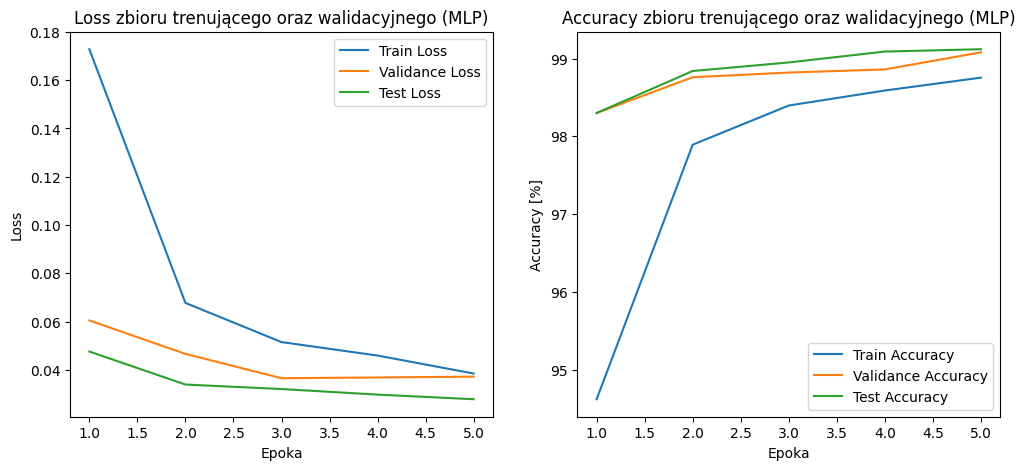

In [54]:
#Wizualizacje wyników Acc. oraz Loss
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validance Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.title("Loss zbioru trenującego oraz walidacyjnego (MLP)")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validance Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.title("Accuracy zbioru trenującego oraz walidacyjnego (MLP)")
plt.xlabel("Epoka")
plt.ylabel("Accuracy [%]")
plt.legend()

plt.show()

Ostatecznie model CNN z ustawionym BatchNorm oraz DropOut:  

*   Osiąga on "accuracy" na ok. 99% (co wydaję się być bardzo dobrym wynikiem)
*   Posiada widoczny progres w nauce (krzywe w większości mają prawidłowy trend: dla "accuracy" dąży co raz to do większej wartości; dla "loss" dąży do jak najmniejszej wartości)
*   Wraz z DropOut oraz BatchNorm wymaga jeszcze większej siły obliczeniowej (czas wykonania: ok. 540 sek.)

**Wnioski**

*   Biorąc pod uwagę dwie sieci **MLP** oraz **CNN** to lepsze wyniki osiąga **CNN**, gdzie natomiast **MLP** cechuje się mniejszymi wymaganiami jeśli chodzi o siłę obliczeniową.
*   Im bardziej zaawansowany jest model tym większej siła obliczeniowa jest potrzebna.
*   Wydaję się być możliwe uzyskanie jeszcze lepszych wyników (paru setek procentów...) poprzez przejście dodatkowych "epok", bądź poprzez inne ustawienie "BatchSize".  





